# <center>  Validation of Reservoir Model (RM) for formation </center>


<b>Idea:</b> The main idea of this tutorial is to demonstrate that the results of the Reservoir Model (RM) (i.e., averaging lithium concentration along the particle) can closely approximate the behavior of the Doyle-Fuller-Newman model (DFN) during relatively low C-rate cycling.





<div class="alert alert-block alert-danger"> <b>Goal</b>  
  <ol>
  <li>It can be used to save CPU time for a large number of cycles
  <li>The model can be used for comparing performance at different C-rates</li>
  <li>It can be used with different SEI growth models</li>
  <li>The mathematical model is much simpler and has fewer parameters</li>
</ol>
</div>

Import the PyBaMM and essentials packages, as well as a set of parameters.


In [ ]:
import pybamm
import numpy as np
param = pybamm.ParameterValues("Chen2020")

In [ ]:
c_rates = ["C/5", "C/10", "C/20", "C/40"]
no_cycles = 20
exps = [pybamm.Experiment(
    [("Charge at {} until 4.2 V".format(c_rates[i]),
      "Rest for 5 hours",
      "Discharge at {} until 2.5 V".format(c_rates[i]),
      "Rest for 5 hours",
      )] * no_cycles,
) for i in range(len(c_rates))]

In [ ]:
name_models = ["DFN", "RM"]  # This is for the legend
models = [
    model
    for model in [
        pybamm.lithium_ion.DFN(
            name=name_models[0]
        ),
        pybamm.lithium_ion.SPM(
            name=name_models[1]
        )
    ]
]

In [ ]:
# You may need to increase maximum number steps as follows:
pybamm.settings.max_y_value = 1000000000
solver = pybamm.CasadiSolver(mode="safe")

# Note that the size of sims will be equal to the number of models times the number of experiments
sims = [pybamm.Simulation(model, parameter_values=param, experiment=exp, solver=solver)
        for exp in exps for model in models]

In [ ]:
sols = [sim.solve(initial_soc=0) for sim in sims]

In [ ]:
out_vars = ['X-averaged negative particle surface concentration [mol.m-3]',
            "Voltage [V]",
            ]

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.cm as cm

plt.style.use('science')  # Use the 'science' style
cmap = cm.get_cmap('tab10')  # Colour map (there are many others)

outPutVar = out_vars[1]
k = 0

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs = axs.flatten()  # Flatten the array of axes to make it easier to iterate over
for j in range(len(c_rates)):
    ax = axs[j]  # Select the subplot to plot on

    X1 = (sols[k]['Throughput capacity [A.h]'].entries)
    Y1 = (sols[k][outPutVar].entries)
    ax.plot(X1, Y1, linestyle='-', color="blue",
            label="DFN", linewidth=2)  # Solid line

    X1 = (sols[k+1]['Throughput capacity [A.h]'].entries)
    Y1 = (sols[k+1][outPutVar].entries)
    ax.plot(X1, Y1, linestyle='--', color="green",
            label="RM", linewidth=2)  # Dotted line
    k += 2
#     ax.legend(fontsize=14)
    ax.set_xlabel("Throughput capacity [A.h]", fontsize=14)
    ax.set_ylabel(outPutVar, fontsize=14)
    ax.set_title(c_rates[j], fontsize=18, color="red")
    # Increase the font size of the ticks
    ax.tick_params(axis='both', which='major', labelsize=14)
    # lines_labels.extend([(line1, line2), ("DFN", "RM")])

fig.legend(("DFN", "RM"), fontsize=18, loc="center", ncol=2)
plt.tight_layout()  # Adjust the layout to prevent overlap
# plt.savefig("figure" + ".png", format='png',
#             dpi=300)  # Save the figure in high quality
plt.show()

Part 2: SEI

In [ ]:
%cd /home/kawamanmi/Projects/PyBaMM
import pybamm
import numpy as np
param = pybamm.ParameterValues("Chen2020")
param['Initial inner SEI thickness [m]'] = 1e-12
param['Initial outer SEI thickness [m]'] = 1e-12

In [ ]:
c_rates = ["C/5", "C/10", "C/20"]
no_cycles = 5
exps = [pybamm.Experiment(
    [("Charge at {} until 4.2 V".format(c_rates[i]),
      "Rest for 5 hours",
      "Discharge at {} until 2.5 V".format(c_rates[i]),
      "Rest for 5 hours",
      )] * no_cycles,
) for i in range(len(c_rates))]

In [ ]:


sei_models = ["electron-migration limited",
              "interstitial-diffusion limited", "ec reaction limited", "Kolzenberg2020"]

Label_sei_models = ["Electron-migration limited 1",
                    "Interstitial-diffusion limited", "Solvent reaction limited", "Electron-migration limited 2"]
# Diffferent SEI models can be used, by setting the index of sei_models
name_models = ["DFN", "RM"]  # This is for the legend
models = [
    model
    for index in range(len(sei_models))
    for model in [
        pybamm.lithium_ion.DFN(
            options={"SEI": sei_models[index], "SEI porosity change": "true"},
            name=name_models[0] + " " + sei_models[index]
        ),
        pybamm.lithium_ion.SPM(
            options={"particle": "uniform profile",
                     "SEI": sei_models[index], "SEI porosity change": "true"},
            name=name_models[1] + " " + sei_models[index]
        )
    ]
]
models

In [ ]:
# You may need to increase maximum number steps as follows:
pybamm.settings.max_y_value = 1000000000
solver = pybamm.CasadiSolver(mode="safe")

# Note that the size of sims will be equal to the number of models times the number of experiments
sims = [pybamm.Simulation(model, parameter_values=param, experiment=exp, solver=solver)
        for model in models for exp in exps]

In [ ]:
sols = [sim.solve(initial_soc=0) for sim in sims]

In [ ]:
out_vars = ['X-averaged negative total SEI thickness [m]', 'X-averaged negative particle surface concentration [mol.m-3]',
            "Voltage [V]",
            ]

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.cm as cm

plt.style.use('science')  # Use the 'science' style
cmap = cm.get_cmap('tab10')  # Colour map (there are many others)

outPutVar = out_vars[0]
k = 0

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs = axs.flatten()  # Flatten the array of axes to make it easier to iterate over
for model in range(len(sei_models)):
    for j in range(len(c_rates)):
        ax = axs[model]  # Select the subplot to plot on
        X1 = (sols[k]['Time [h]'].entries)
        Y1 = (sols[k][outPutVar].entries)
        ax.plot(X1, Y1, linestyle='-',
                label="DFN " + str(c_rates[j]), linewidth=2)  # Solid line

        X1 = (sols[k+1]['Time [h]'].entries)
        Y1 = (sols[k+1][outPutVar].entries)
        ax.plot(X1, Y1, linestyle=':',
                label="RM " + str(c_rates[j]), linewidth=2)  # Dotted line
        k += 2
        # ax.legend(fontsize=14)
        ax.set_xlabel('Time [h]', fontsize=14)
        ax.set_ylabel("$L_\mathrm{SEI}$ [nm]", fontsize=14)
        ax.set_title(Label_sei_models[model], fontsize=18, color="red")
# Add a rotated arrow to the subplot
        # ax.annotate("", xy=(70, 3e-10), xytext=(50, 5e-10),
        #             arrowprops=dict(arrowstyle="->", lw=2, color="k"))
    # Increase the font size of the ticks
        ax.tick_params(axis='both', which='major', labelsize=14)
    # lines_labels.extend([(line1, line2), ("DFN", "RM")])

# fig.legend(("DFN", "RM"), fontsize=18, loc="center", ncol=2)
plt.tight_layout()  # Adjust the layout to prevent overlap
# plt.savefig("figure2" + ".png", format='png',
#             dpi=300)  # Save the figure in high quality
plt.show()

Part 3: How SEI behaves at first and subsequent cycles:

In [ ]:
%cd /home/kawamanmi/Projects/PyBaMM
import pybamm
import numpy as np
param = pybamm.ParameterValues("Chen2020")
param['Initial inner SEI thickness [m]'] = 1e-12
param['Initial outer SEI thickness [m]'] = 1e-12

c_rates = ["C/5", "C/10", "C/20", "C/40"]
no_cycles = 2
exps = [pybamm.Experiment(
    [("Charge at {} until 4.2 V".format(c_rates[i]),
      "Rest for 5 hours",
      "Discharge at {} until 2.5 V".format(c_rates[i]),
      "Rest for 5 hours",
      )] * no_cycles,
) for i in range(len(c_rates))]

In [ ]:


sei_models = ["electron-migration limited",
              "interstitial-diffusion limited", "ec reaction limited", "Kolzenberg2020"]

Label_sei_models = ["Electron-migration limited 1",
                    "Interstitial-diffusion limited", "Solvent reaction limited", "Electron-migration limited 2"]
# Diffferent SEI models can be used, by setting the index of sei_models
models = [
    pybamm.lithium_ion.SPMe(
        options={"SEI": sei_models[index], "SEI porosity change": "true"},
        name=sei_models[index]
    ) for index in range(len(sei_models))
]
sims = [pybamm.Simulation(model, parameter_values=param,
                          experiment=exp, solver=solver) for model in models for exp in exps]

In [ ]:
sols = [sim.solve(initial_soc=0) for sim in sims]

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.cm as cm

plt.style.use('science')  # Use the 'science' style
cmap = cm.get_cmap('tab10')  # Colour map (there are many others)

outPutVar = out_vars[0]
k = 0

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs = axs.flatten()  # Flatten the array of axes to make it easier to iterate over
for model in range(len(sei_models)):
    for j in range(len(c_rates)):
        ax = axs[model]  # Select the subplot to plot on
        X1 = (sols[k].cycles[0]['Time [h]'].entries)
        Y1 = (sols[k].cycles[0][outPutVar].entries)
        ax.plot(X1, Y1, linestyle='-',
                label="DFN " + str(c_rates[j]), linewidth=2)  # Solid line

        X2 = (sols[k].cycles[1]['Time [h]'].entries)-X1[-1]
        Y2 = (sols[k].cycles[1][outPutVar].entries) - Y1[-1]
        ax.plot(X2, Y2, linestyle=':',
                label="RM " + str(c_rates[j]), linewidth=2)  # Dotted line
        k += 1
        # ax.legend(fontsize=14)
        ax.set_xlabel('Time [h]', fontsize=16)
        ax.set_ylabel("SEI growth [nm]", fontsize=16)
        ax.set_title(Label_sei_models[model], fontsize=18, color="red")
# Add a rotated arrow to the subplot
        # ax.annotate("", xy=(70, 3e-10), xytext=(50, 5e-10),
        #             arrowprops=dict(arrowstyle="->", lw=2, color="k"))
    # Increase the font size of the ticks
        ax.tick_params(axis='both', which='major', labelsize=16)
    # lines_labels.extend([(line1, line2), ("DFN", "RM")])

# fig.legend(("DFN", "RM"), fontsize=18, loc="center", ncol=2)
plt.tight_layout()  # Adjust the layout to prevent overlap
# plt.savefig("figure" + ".png", format='png',
#             dpi=300)  # Save the figure in high quality
plt.show()

In [39]:
%cd /home/kawamanmi/Projects/PyBaMM
import pybamm
import numpy as np
param = pybamm.ParameterValues("Chen2020")
param['Initial inner SEI thickness [m]'] = 1e-12
param['Initial outer SEI thickness [m]'] = 1e-12

c_rates = ["C/5", "C/10", "C/20", "C/40"]
no_cycles = 2
exps = [pybamm.Experiment(
    [("Charge at {} until 4.2 V".format(c_rates[i]),
      "Rest for 5 hours",
      "Discharge at {} until 2.5 V".format(c_rates[i]),
      "Rest for 5 hours",
      )] * no_cycles,
) for i in range(len(c_rates))]

/home/kawamanmi/Projects/PyBaMM


In [40]:
# You may need to increase maximum number steps as follows:
pybamm.settings.max_y_value = 1000000000
solver = pybamm.CasadiSolver(mode="safe")

# Note that the size of sims will be equal to the number of models times the number of experiments
sims = [pybamm.Simulation(model, parameter_values=param, experiment=exp, solver=solver)
        for model in models for exp in exps]

In [41]:


sei_models = ["ec reaction limited",
              "solvent-diffusion limited", "reaction limited"]

Label_sei_models = ["Solvent-diffusion + reaction  limited",
                    "Solvent-diffusion limited", "Reaction limited"]
# Diffferent SEI models can be used, by setting the index of sei_models
models = [
    pybamm.lithium_ion.SPM(
        options={"SEI": sei_models[index], "SEI porosity change": "true"},
        name=sei_models[index]
    ) for index in range(len(sei_models))
]
sims = [pybamm.Simulation(model, parameter_values=param,
                          experiment=exp, solver=solver) for model in models for exp in exps]

In [42]:
sols = [sim.solve(initial_soc=0) for sim in sims]

In [43]:
out_vars = ['X-averaged negative total SEI thickness [m]', 'X-averaged negative particle surface concentration [mol.m-3]',
            "Voltage [V]",
            ]

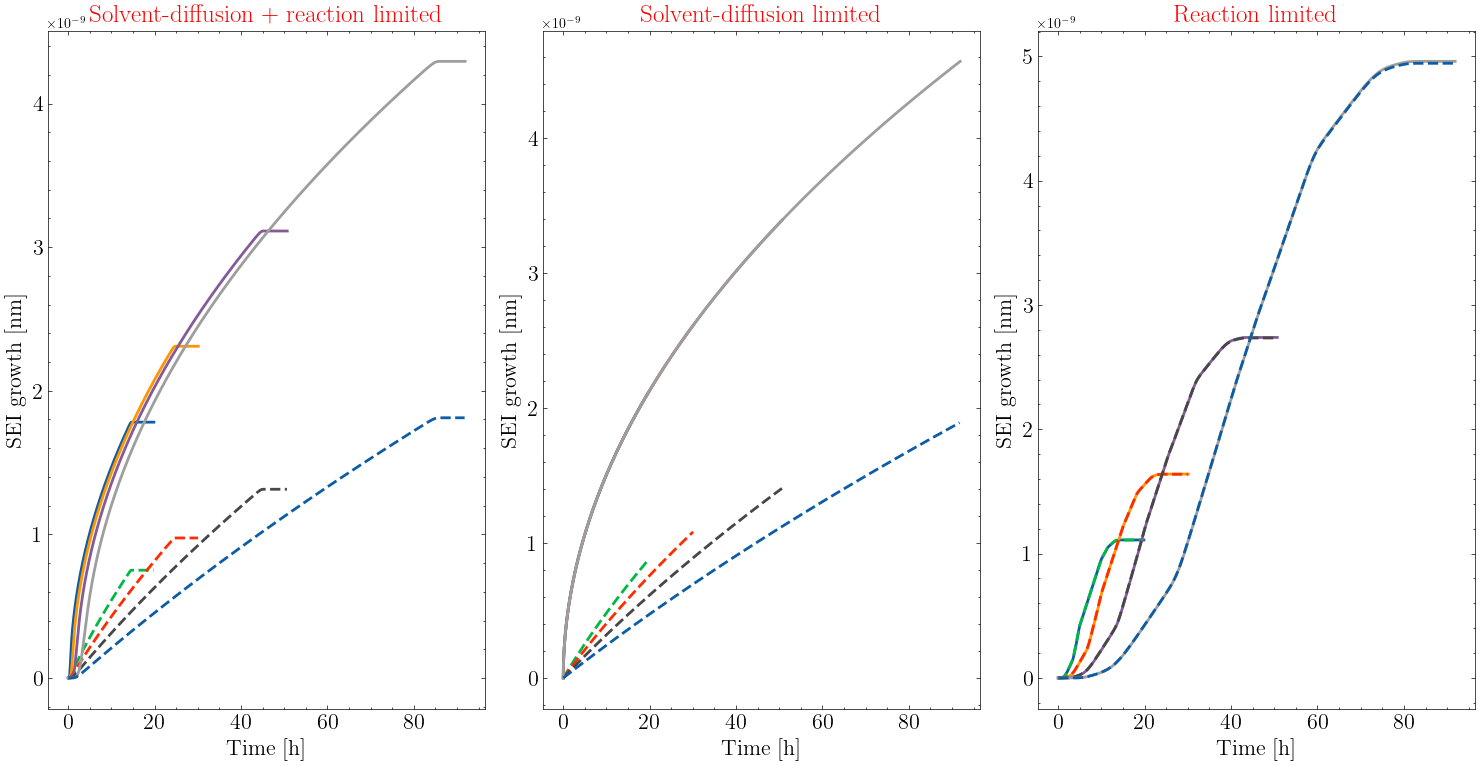

In [45]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.cm as cm

plt.style.use('science')  # Use the 'science' style
cmap = cm.get_cmap('tab10')  # Colour map (there are many others)

outPutVar = out_vars[0]
k = 0

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
axs = axs.flatten()  # Flatten the array of axes to make it easier to iterate over
for model in range(len(sei_models)):
    for j in range(len(c_rates)):
        ax = axs[model]  # Select the subplot to plot on
        X1 = (sols[k].cycles[0]['Time [h]'].entries)
        X1 = X1 - X1[0]
        Y1 = (sols[k].cycles[0][outPutVar].entries)
        Y1 = Y1 - Y1[0]
        ax.plot(X1, Y1, linestyle='-',
                label="DFN " + str(c_rates[j]), linewidth=2)  # Solid line

        X2 = (sols[k].cycles[1]['Time [h]'].entries)
        X2 = X2-X2[0]
        Y2 = (sols[k].cycles[1][outPutVar].entries)
        Y2 = Y2 - Y2[0]
        ax.plot(X2, Y2, linestyle='--',
                label="RM " + str(c_rates[j]), linewidth=2)  # Dotted line
        k += 1
        # ax.legend(fontsize=14)
        ax.set_xlabel('Time [h]', fontsize=16)
        ax.set_ylabel("SEI growth [nm]", fontsize=16)
        ax.set_title(Label_sei_models[model], fontsize=18, color="red")
# Add a rotated arrow to the subplot
        # ax.annotate("", xy=(70, 3e-10), xytext=(50, 5e-10),
        #             arrowprops=dict(arrowstyle="->", lw=2, color="k"))
    # Increase the font size of the ticks
        ax.tick_params(axis='both', which='major', labelsize=16)
    # lines_labels.extend([(line1, line2), ("DFN", "RM")])

# fig.legend(("DFN", "RM"), fontsize=18, loc="center", ncol=2)
plt.tight_layout()  # Adjust the layout to prevent overlap
# plt.savefig("figure" + ".png", format='png',
#             dpi=300)  # Save the figure in high quality
plt.show()

# Discussion: 

In this notebook, we demonstrated that the Reservoir Model (RM) agrees well with the full DFN model at low C-rates $\le$ C/10 for all avaliable SEI models. The notebook also provides flexibility to compare more than two models and simulate performance across many different C-rates and cycles.

## References

The relevant papers for this notebook are:

In [ ]:
pybamm.print_citations()